© `abhirup.ghosh.184098@gmail.com`

# Next steps
* go through the code again
* go through the report again
* write section on follow-ups

# HAMS Data Science Challenge

The details of the data science challenge can be found [here](https://github.com/haensel-ams/recruitment_challenge/tree/master/DataScience_202209). 

The task was to:
1. build a Bayesian MMM with the latest [PyMC package](https://www.pymc.io/)
2. test it on the [given dataset](https://github.com/haensel-ams/recruitment_challenge/blob/master/DataScience_202209/MMM_test_data.csv)
3. interpret the insights from the model

To help with point 3., some questions were already provided:
* How do you model spend carry over?
* Explain your choice of prior inputs to the model?
* How are your model results based on prior sampling vs. posterior sampling?
* How good is your model performing? How you do measure it?
* What are your main insights in terms of channel performance/ effects?
* (Bonus) Can you derive ROI (return on investment) estimates per channel? What is the best channel in terms of ROI?

which we hope to answer in the analysis below.

# Resources

I put together a summary of the resources I referred to during this challenge. This includes resources for a quick overview of the problem, more in-depth research articles and publicly-available implementations of Bayesian mixed media modelling.

* Quick Overview:
  * [Marketing Mix Modelling: Wikipedia](https://en.wikipedia.org/wiki/Marketing_mix_modeling)
  * [Media mix modeling (MMM): AppsFlyer](https://www.appsflyer.com/glossary/media-mix-modeling/)
* Research articles:  
  * [Bayesian Methods for Media Mix Modeling with Carryover and Shape Effects, Jin et al, Google Inc. (2017)](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf)
  * Caveats/Follow-ups:
    * [Challenges And Opportunities In Media Mix Modeling, D. Chan and M. Perry, Google Inc. (2017)](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45998.pdf)
    * [Bias Correction For Paid Search In Media Mix Modeling, Chen et al (2018)](https://arxiv.org/abs/1807.03292)
* Blog posts:
  * [Bayesian Media Mix Modeling for Marketing Optimization](https://www.pymc-labs.io/blog-posts/bayesian-media-mix-modeling-for-marketing-optimization/)
  * [Improving the Speed and Accuracy of Bayesian Media Mix Models](https://www.pymc-labs.io/blog-posts/reducing-customer-acquisition-costs-how-we-helped-optimizing-hellofreshs-marketing-budget/)
  * [Bayesian Media Mix Modeling using PyMC3, for Fun and Profit: HelloFresh](https://engineering.hellofresh.com/bayesian-media-mix-modeling-using-pymc3-for-fun-and-profit-2bd4667504e6)
  * [BayesianMMM — State of the Art Media Mix Modelling](https://towardsdatascience.com/bayesianmmm-state-of-the-art-media-mix-modelling-9207c4445757)
* Publicly available codes:
  * [pymc-marketing](https://github.com/pymc-labs/pymc-marketing) from [pymc](https://www.pymc.io/welcome.html) with [example implementation](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html) with [pymc-marketing](https://github.com/pymc-labs/pymc-marketing)
  * [BayesianMMM](https://github.com/leopoldavezac/BayesianMMM) related to the blog post [BayesianMMM — State of the Art Media Mix Modelling](https://towardsdatascience.com/bayesianmmm-state-of-the-art-media-mix-modelling-9207c4445757) [uses STAN]

# Environment

We can run the code in a conda environment that can be installed using the `.env.txt` provided with this notebook. All additional depenencies were installed using the `pip` inside the environment, using the command given below.

In [1]:
#! pip install pandas seaborn numpy matplotlib scikit-learn jupyter pymc pymc_marketing graphviz

Questions:
* revenue/spends units euros
* what value of L
* log revenue
* control variables?
* normalise the revenue/spend variables


Variables:
* carryover function
* shape function
* priors
* likelihood choices

# Analysis

## Dependencies

In [2]:
# dependencies 
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymc as pm

# set plotting style
sns.set_style("whitegrid")

from typing import Any, Dict, List, Optional

from pymc_marketing.mmm.base import MMM
from pymc_marketing.mmm.preprocessing import MaxAbsScaleChannels, MaxAbsScaleTarget
from pymc_marketing.mmm.transformers import delayed_adstock, logistic_saturation
from pymc_marketing.mmm.validating import ValidateControlColumns


%load_ext autoreload
%autoreload 2

<span style="color:red">CODE:</span> I found an extremely helpful package called [pymc-marketing](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html) which already incorporated quite a few elements of this analysis. Wherever possible, I reuse their code, instead of building everything from scratch.

## Loading Data: MMM_test_data.csv

The dataset consists of:
* `start_of_week`: first day of the week `(time variable)`
* `revenue`: revenue generated in this week from sales `(target/dependent variable)` [assumption: revenue is in euros]
* `spend_channel_1..7`: marketing cost spend in this week in channel 1..7 `(independent variables)`


In [3]:
# Assumes data file (MMM_test_data.csv) 
# lies in the same folder as the notebook

df = pd.read_csv('./MMM_test_data.csv', parse_dates=['start_of_week'], dayfirst=True) # assigning 'start_of_week' as a datetime-type column
#df.info() # to ensure there are no NULLs and all variables are the correct type
df.head().T

,0,1,2,3,4
start_of_week,2020-08-30 00:00:00,2020-09-06 00:00:00,2020-09-13 00:00:00,2020-09-20 00:00:00,2020-09-27 00:00:00
revenue,157906.75,186425.68,161607.39,180089.13,217793.98
spend_channel_1,2625.48,2634.01,2087.08,1690.7,1547.3
spend_channel_2,262.71,108.66,110.32,52.79,80.56
spend_channel_3,12954.12,8760.28,7155.42,15185.22,18524.05
spend_channel_4,3609.63,4560.6,4362.96,3883.41,4043.09
spend_channel_5,12955.29,12747.7,15015.41,15521.41,15793.74
spend_channel_6,12659.12,12338.18,10811.15,12890.22,12642.55
spend_channel_7,19379.79,22473.45,22596.05,24728.73,26515.48


## Conventions/Notations

Here, we would follow the conventions/notations of [Jin et al, Google Inc. (2017)](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf).

### **Media variables**

$x_{t,m}$: **scaled** media spend on channel $m$ in week $t$ 

for week number $t=1,...,T$   
and for media channel $m=1,...,M$

**Scaling:** One could use several scalings, eg, max-min scaling, absolute max scaling etc.

**NOTE** [[Information provided in the challenge]](https://github.com/haensel-ams/recruitment_challenge/tree/master/DataScience_202209#context): In terms of channels think of TV, radio, billboards, but also online advertisement such as Google Ads, Facebook Ads, etc. So different channel can be expected to target different audiences at different times, and hence will have very different effects on future sales.

In [4]:
# the week number is indicated by the dataframe index

T = len(df) # total number of weeks/observations
print(f"Total number of weeks/observations, T: {T}")
M = 7 # number of media channels

# We also redefine the `spend_channel_1...7` column names to `x1...7`, for the sake of brevity and matching conventions.
df.columns = ['start_of_week', 'revenue', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']

Total number of weeks/observations, T: 104


<span style="color:red">WARNING</span>: sample size (104) is relatively small, and hence, following [Jin et al, Google Inc. (2017)](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf), one must be aware of possible biased estimates due to non-trivial impact of the prior on the parameter posteriors.

### **Non-media/control variables**

As mentioned in [Jin et al, Google Inc. (2017)](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf), non-media variables, eg, price, product distribution, seasonality, etc, can have affect revenue. These can be referred to as **non-media/control** variables, defined as:  

$z_{t,c}$: value of the $c$-th control variable in week $t$

### **Dependent variables: Revenue**

The dependent variable is what we aim to predict, i.e., the quantity that changes in media and non-media variables are likely to affect, e.g., sales, revenue, etc. We scale the dependent variable in the same way we scale the media variables. Hence:

$y_t$: **scaled** revenue in week $t$

## Data Pre-processing: Data cleaning/EDA

### **Date Range**

The data spans a **2 year** time period. 

In [5]:
print(f"{df.start_of_week.min().date()} -- {df.start_of_week.max().date()}")

2020-08-30 -- 2022-08-21


**Adding some datetime information:** We explicitly add `dayofyear`, which will help with modelling seasonality later.

In [6]:
df = df.assign(
    dayofyear=lambda x: x["start_of_week"].dt.dayofyear,
)

**Note**: If we need a time-index for the week-number, we can just use the dataframe index.

### **Media channels/Revenue**

We plot all the spend channels, `x_i`s, and our dependent variable `revenue`. Some immediate insights we draw from these time series are:

* `revenue` (plot[2,4]) shows some seasonality, **but also** a monotonically decreasing trend
* spends in certain channels (`x1,5,6`) have recently tailed off, while
* spends in other channels (`x2,7`) have recently been increased
* spends in the rest (`x3,4`) have remained constant during the time period considered

More insights will follow in our modelling below.

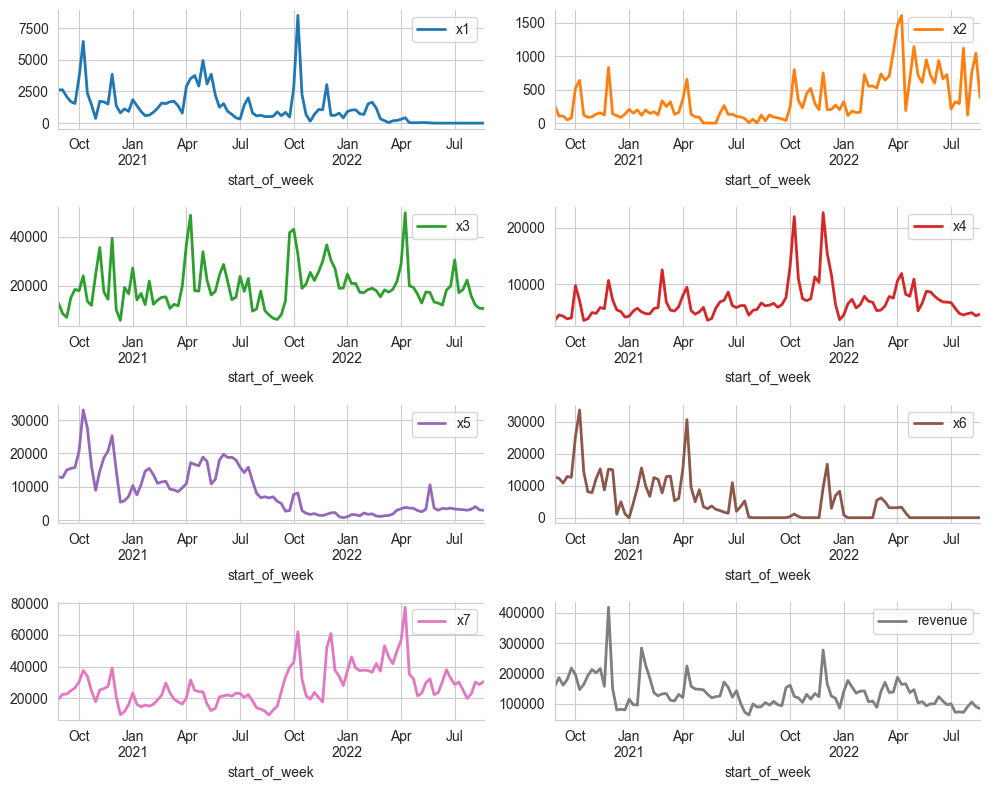

In [7]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)

colors = [f"C{i}" for i in range(8)]

for ax,x,c in zip(axs.ravel(), [f"x{i}" for i in range(1,8)] + ['revenue'], colors):
    # filter df for ticker and plot on specified axes
    df.plot(x='start_of_week', y=x, color=c, lw=2, ax=ax)
    ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()

We also compare the individual media variable time series with the revenue time series, to check for correlations between the two.

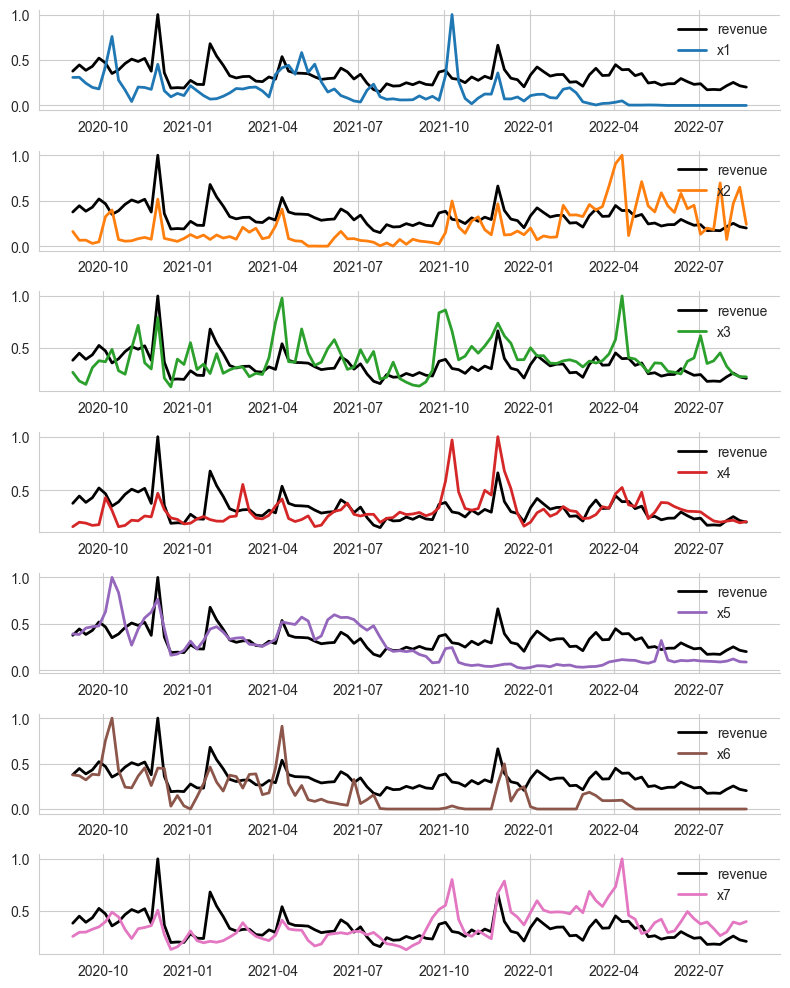

In [8]:
fig, axs = plt.subplots(nrows=7, ncols=1, figsize=(8, 10))
plt.subplots_adjust(hspace=0.5)

colors = [f"C{i}" for i in range(7)]

for ax,x,c in zip(axs.ravel(), [f"x{i}" for i in range(1,8)], colors):
    ax.plot(df['start_of_week'], df['revenue']/df['revenue'].max(), color='k', lw=2, label='revenue')
    ax.plot(df['start_of_week'], df[x]/df[x].max(), color=c, lw=2, label=x)
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend(loc='upper right', frameon=False)

plt.tight_layout()

## Modelling: Theory

> **Media mix models are used by advertisers to measure the effectiveness of their advertising and provide insight in making future budget allocation decisions.**  
[[Jin et al, Google Inc. (2017)](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf)]

Media-mixed-models (MMM) are multi-linear regression models that try to capture **three things**:
* Shape effect: How do sales respond to media spend? What is the reach of a marketing campaign? When does the ad effect saturate and start showing diminishing returns?
* Carryover/lag effect: Does the marketing spend in a given channel have a short- or long-term impact?
* Other relevant factors (eg, 4Ps): How does the outside world-at-large impact marketing? Eg, macroeconomic forces, weather, seasonality, and market competition.

The first two effects are properties of the media variables, while the third affect the control variables. We will include each of these effects (to various levels of detail) in our model.

### **Media variables**

#### **1. Carryover effect**

**Definition:** Change in sales caused by an exposure of advertising *occurring in time periods following the pulse of advertising*. This may be due to delayed consumer response, delayed purchase due to consumers’ inventory, or purchases from consumers who have heard from those who first saw the ad. To model the carryover effect of advertising, we transform the time series of media spend in one channel, $x_{t, m}$, through the **adstock function**:

$$x^*_{t,m} = \text{adstock}(x_{t-L+1, m},...,x_{t, m}; w_m, L) = \frac{\sum_{l=0}^{L+1}w_m(l)x_{t-l,m}}{\sum_{l=0}^{L+1}w_m(l)}$$

in order to obtain $x^*_{t,m}$, **the cumulative media effect as a weighted average of media spend in the current week and previous L − 1 weeks.** Here:

* $w_m$: nonnegative weight function  
* $L$: maximum duration of carryover effect assumed for a medium (without prior information, set to very large value)

There are a couple of ways the carryover effect can be modelled, depending on our choice of the weight function $w_m$.

##### **1.1. Geometric decay adstock**
which assumes **advertising effect peaks at the same time period as ad exposure**:

$$w_m^g (l;\alpha_m)=\alpha_m^l, \quad l=0,...,L−1, \quad 0< \alpha_m <1$$
$\alpha_m$:  retention rate of ad effect of the $m$-th media from one period to the next.

##### **1.2. Delayed adstock**
which assumes some media may take longer to build up ad effect and the peak effect may not happen immediately:

$$w_m^d (l;\alpha_m, \theta_m)=\alpha_m^{(l−\theta_m)^2}, \quad l=0,...,L−1, \quad  0< \alpha <1, \quad  0 \leq \theta_m \leq L−1$$

$\theta_m$: delay of the peak effect.

Figure 1 in [Jin et al, Google Inc. (2017)](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf) shows the weight functions of geometric adstock and delayed adstock for the same value of $\alpha_m$.

#### **2. Shape effect**

**Definition:** Change in sales caused by ad saturation and diminishing returns at high levels of spend [Tellis (2006)]. This causes the response of sales to the media variable to deviate from linearity by assuming changes on account of ad saturation and diminsihing returns. To model shape effects, we transform the media spend through a **curvature function**. Below we provide three options, two provided by [[Jin et al, Google Inc. (2017)](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf)] and the third provided in [here]((https://engineering.hellofresh.com/bayesian-media-mix-modeling-using-pymc3-for-fun-and-profit-2bd4667504e6)).

##### **2.1. $\beta$ Hill function**

$\beta_m\text{Hill}_m(x_{t,m};K_m,S_m) = \frac{\beta_m}{1 + (x_{t,m}/Km)^{−Sm}}, \quad \quad x_{t,m} \geq 0 $

where:
* $\beta_m$: regression coefficient to allow different maximum effects for different media
* $S_m > 0$: shape parameter/slope
* $K_m > 0$: half saturation point

**According to [[Jin et al, Google Inc. (2017)](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf)], $\beta$Hill has poor identifiability which makes it very challenging to estimate the parameters well with any statistical method. Hence we are not gonig to use it for our analysis.**

##### **2.2. Reach transformation**

describing the unique relationship between unique reach and Gross Rating Points (GRPs) or impressions of a TV campaign

$R_m=a_m − \frac{b_m}{G_m+b_m/a_m} \longrightarrow R_m = \beta_m\text{Hill}_m | S_m = 1, a_m = \beta_m, b_m = \beta_mK_m$

where:
* $R_m$: reach, i.e, number of people in the target audience reached by a campaign divided by the total size of the audience, of $m$-th media variable
* $G$: GRP, number of impressions delivered to the target audience divided by the number of people in the target audience, multiplied by 100, of $m$-th media variable

##### **2.3. Logistic Saturation**

$\beta_m L_m = \frac{1 - e^{-\lambda x_{t,m}}}{1 + e^{-\lambda x_{t,m}}}$

where:
* $\lambda_m$: half-saturation point of the m-th media variable
* $\beta_m$: regression coefficient to allow different maximum effects for different media


#### **3. Order of carryover and shape transformations**

> If media spend in each time period is relatively small compared to the cumulative spend across multiple time periods, the shape effect in each time period is less obvious compared to that of cumulative media spend. In this case, we would prefer to apply the shape transformation after the adstock transformation. However, if the media spend is heavily concentrated in some single time periods with an on-and-off pattern, the latter choice might be preferable. [[Jin et al, Google Inc. (2017)](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf)]

### **Non-media/Control variables**

#### **1. Trend & Seasonal Components**

Seasonality provides sinusoidal pattern to the revenue above some baseline revenue we call the **intercept, $\tau$**. However, the baseline revenue itself might be affect by macroeconomic factors, eg, recession, inflation, etc, and show an over all trend, which we **assume linear** here.

In [9]:
from pymc_marketing.mmm.utils import generate_fourier_modes

# Fourier modes
fourier_modes = generate_fourier_modes(
    periods=df["dayofyear"] / 365.25,
    n_order=2 # model annual and half-yearly seasonality
)

# trend feature: assume a linear trend
df["t"] = range(T)

df = pd.concat([df, fourier_modes], axis=1)

df.head()

,start_of_week,revenue,x1,x2,x3,x4,x5,x6,x7,dayofyear,t,sin_order_1,cos_order_1,sin_order_2,cos_order_2
0,2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79,243,0,-0.861693,-0.507430,0.874498,-0.485029
1,2020-09-06,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45,250,1,-0.916409,-0.400244,0.733574,-0.679610
2,2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05,257,2,-0.957852,-0.287261,0.550307,-0.834962
3,2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73,264,3,-0.985424,-0.170118,0.335276,-0.942120
4,2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48,271,4,-0.998724,-0.050511,0.100892,-0.994897


#### **2. Other Control Variables**

We add three events where there was a remarkable peak in revenue. We assume they are independent of seasonality (perhaps. launch of a particular product?). As threshold for unnatural peaks, we use 250,000 euros in daily revenue.

In [10]:
# df[df.revenue > 250000].start_of_week

df["event_1"] = (df["start_of_week"] == "2020-11-29").astype(float)
df["event_2"] = (df["start_of_week"] == "2021-01-24").astype(float)
df["event_3"] = (df["start_of_week"] == "2021-11-28").astype(float)

## Modelling: Use-case

### **Steps [and Code]**

1. **Variable Scaling: Maximum Absolute Scaling** 

    * Reason: We rescale our media variables and target variable (revenue) using a maximum absolute scaling function. This places all the variables on a similar scale and provides greater stability and robustness to the model evaluation.
    * Code: [pymc-marketing: MaxAbsScaleChannels](https://github.com/pymc-labs/pymc-marketing/blob/846e553e55a4f2a68ce0ad85793a569f81496209/pymc_marketing/mmm/preprocessing.py#L35) and [pymc-marketing: MaxAbsScaleTarget](https://github.com/pymc-labs/pymc-marketing/blob/846e553e55a4f2a68ce0ad85793a569f81496209/pymc_marketing/mmm/preprocessing.py#L22)
  
2. **Carryover effect: delayed adstock transformation with L=13** 

    * Reason: From a comparison of the maximum-absolute-scaled media variables and revenue time series, we see for most of the media variables (prominently for `x1`, `x2`, `x5`) there is a delayed response in revenue, i.e, a peak in the media spend is followed after some time with a peak in the revenue. While, there are other variables which do not show any prominent delayed response and could have been modelled using a geometric adstock function, for simplicity we use the delayed adstock function for all the media variables.
    * Code: [pymc-marketing: delayed_adstock](https://github.com/pymc-labs/pymc-marketing/blob/846e553e55a4f2a68ce0ad85793a569f81496209/pymc_marketing/mmm/transformers.py#L103)

3. **Shape effect: logistic saturation curvature transformation**

    * Reason: As mentioned above, according to [[Jin et al, Google Inc. (2017)](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf)], $\beta$Hill has poor identifiability which makes it very challenging to estimate the parameters well with any statistical method. Hence we are not gonig to use it for our analysis. The Reach function is better used for TV, radio channels. However we would need more information about what the media channels are to appropriately allocate the reach function. In the mean time we use the flexible logistic function for all channels.
    * Code: [pymc-marketing: logistic_saturation]([pymc-marketing: delayed_adstock](https://github.com/pymc-labs/pymc-marketing/blob/846e553e55a4f2a68ce0ad85793a569f81496209/pymc_marketing/mmm/transformers.py#L103)

4. **Order of Transformations: first carryover, second shape**

    * Reason: Although in a few channels (eg, `x4`, `x7`) the media spend appears to be heavily concentrated in some single time periods with an on-and-off pattern, for most of the channels, the media spends in each time period are relatively small compared to the cumulative spend across multiple time periods. Hence, we generalise and assume that the latter is the true for all, and if we perform the shape transformation before the carryover transformation, information about the shape might be lost.

5. **Control variables: Trend/seasonality/exceptional revenue spikes**

    * The trend is assumed linear
    * The seasonality is assumed sinusoidal
    * The control events are assumed peaks in revenue (> 250,000)

## **Final Model**

$$\hat{y}_t = \tau + \sum_{m=1}^M \beta_m L_m(x^*_{t,m}(\alpha_m, \theta_m, L), \lambda) + \sum_{c=1}^C \gamma_c z_{t,c}$$

where:

* $\hat{y}_t$: prediction for the **rescaled** revenue, $y_t$ in week $t$ ($y_t$: dependent variable)
* $\tau$: intercept/baseline revenue
* $\beta_m$: regression coefficient during shape-effect modelling 
* $L_m$: logistic saturation curvature function with a half-saturation $\lambda$ to model shape effect
* $x^*_{t,m}$: adstock transformed variable corresponding to **scaled** media variable $x_{t,m}$
* $\alpha_m$: retention rate of ad effect of the $m$-th media from one period to the next.
* $\theta_m$: delay of the peak effect.
* $L$: maximum duration of carryover effect assumed for a medium (without prior information, set to very large value = 13)
* $\gamma_c$: effect of control variable $z_c$

#### **Parameter set**

The model is described by the parameter set:

$$\Phi = \{\tau, \beta_m, \lambda_m, \alpha_m, \theta_m, \gamma_c\}$$

# Bayesian Inference

We assume our weekly revenue $y_t$ [from the data file] to be an additive model of our predicted revenue $\hat{y}_t(\Phi)$ and some white noise, $\epsilon_t(\sigma)$, defined as:

$$y_t = \hat{y}_t(\Phi) + \epsilon_t(\sigma)$$

where our model prediction depends on the parameter set $\Phi$ and we assume our **noise follows a Gaussian distribution with zero mean and standard deviation $\sigma$, i.e, $\sim N(0,\sigma)$ and uncorrelated with the other variables in the model.**  Thus the posterior probability distribution of the parameter $\Phi$, $p(\Phi)$ is given by the Bayes' Theorem:
Given the model $\hat{y}_t (\Phi)$, given above, to describe the revenue $y_t$ in the week $t$, the posterior probability dist

$$p(\Phi | y) \propto \pi(\Phi) \mathcal{L}(y | \Phi)$$

where $\pi(\Phi)$ is the prior probability distribution of our parameters and $\mathcal{L}(y | \Phi)$ is the likelihood function. With a given definition of the likelihood function, we proceed to stochastically sample the parameter space using an MCMC algorithm coded up inside the **pymc-marketing/pymc** packages.

## **Specifications**

### **Likelihood**
Since we assume our noise to be well described by a Gaussian distribution with $N(0, \sigma)$, our likelihood function is defined as:

$$\mathcal{L}(y | \Phi) \propto < \text{exp}\Big[ -\frac{1}{2} <y - \hat{y}(\Phi) | y - \hat{y}(\Phi)> \Big]$$
where $<a|b>$ denotes the inner product of variables $a$ and $b$.

### **Priors**

| Parameter  | Prior | Reasons for Choice |
|--|--|--|
| $\tau$ | $\text{Normal}(0,2)$ |  |
| $\alpha$ | $\text{Beta}(1,3)$ | $\alpha \in [0, 1)$;  Other choices: Uniform() |
| $\theta$ | $\text{Uniform}(0,12)$ | $\theta \in [0, L)$ and here $L=13$; Other choices: Beta() |
| $L$ | $13$ | Without prior information, L can be set to a very large number, as an approximation to infinity, so the weights $w_m(l) \sim 0$ for $l > L$ | 
| $\beta$ | $\text{HalfNormal}(0,1)$ | $\beta_m > 0$, since media effect is assumed non-negative
| $\lambda$ | $\text{Gamma}(3,1)$ | Following [Jin et al, Google Inc. (2017)](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf) which says a common prior is a gamma distribution with a positive mode.
| $\gamma$ | $\text{Normal}(0,2)$ |
| $\sigma$ | $\text{HalfNormal}(0,2)$ |

### Model Class

In [11]:
# Credit: https://github.com/pymc-labs/pymc-marketing/blob/846e553e55a4f2a68ce0ad85793a569f81496209/pymc_marketing/mmm/delayed_saturated_mmm.py#L12
# The function below differs from the above function in that it uses delayed_adstock instead of geometric_adstock

class DelayedSaturatedMMM_mod(
    # Interiting base model and preprocessing instances
    MMM, # base class for the media-mixed-model coded up in pymc-marketing
    MaxAbsScaleTarget, # maximum-absolute-scaling for the target/revenue variable
    MaxAbsScaleChannels, # maximum-absolute-scaling for the media variables
    ValidateControlColumns # ensure control columns are valid
):
    def __init__(
        self,
        data: pd.DataFrame,
        target_column: str, # target/revenue column
        date_column: str, # date column
        channel_columns: List[str], # spend_channel1...7 or x1...7 columns
        validate_data: bool = True,
        control_columns: Optional[List[str]] = None, # trends/seasonality/exceptional events
        adstock_max_lag: int = 4, # denoted by L in the model
        **kwargs,
    ) -> None:
        self.control_columns = control_columns
        self.adstock_max_lag = adstock_max_lag
        super().__init__(
            data=data,
            target_column=target_column, # target/revenue column
            date_column=date_column, # date column
            channel_columns=channel_columns, # spend_channel1...7 or x1...7 columns
            validate_data=validate_data,
            adstock_max_lag=adstock_max_lag, # denoted by L in the model
        )

    ########################################################################
    # Model: predicted revenue
    ########################################################################
    def build_model(
        self,
        data: pd.DataFrame,
        adstock_max_lag: int = 4,
    ) -> None:
        date_data = data[self.date_column]
        target_data = data[self.target_column]
        channel_data = data[self.channel_columns]
        if self.control_columns is not None:
            control_data: Optional[pd.DataFrame] = data[self.control_columns]
        else:
            control_data = None
        coords: Dict[str, Any] = {
            "date": date_data,
            "channel": channel_data.columns,
        }

        # initialising control data
        if control_data is not None:
            coords["control"] = control_data.columns

        # initialising channel data
        with pm.Model(coords=coords) as self.model:
            channel_data_ = pm.MutableData(
                name="channel_data",
                value=channel_data,
                dims=("date", "channel"),
            )

            ########################################################################
            # Priors
            # (commented out lines indicate other priors experimented with)
            ########################################################################

            target_ = pm.MutableData(name="target", value=target_data, dims="date")

            intercept = pm.Normal(name="intercept", mu=0, sigma=2) # base revenue/sales

            beta_channel = pm.HalfNormal( # regression coefficient for shape effect
                name="beta_channel", sigma=1, dims="channel"
            )

            alpha = pm.Beta(name="alpha", alpha=1, beta=3, dims="channel") # retention rate
            #alpha = pm.Uniform(name="alpha", lower=0, upper=1, dims="channel")

            theta = pm.Uniform(name='theta', lower=0, upper=12, dims="channel") # delay effect

            lam = pm.Gamma(name="lam", alpha=3, beta=1, dims="channel") # saturation effect
            #lam = pm.Gamma(name="lam", alpha=3, beta=3, dims="channel")

            sigma = pm.HalfNormal(name="sigma", sigma=2) # white noise variance
            # sigma = pm.HalfNormal(name="sigma", sigma=5)
            # sigma is a slight misnomer, it should be actually be sigma2, 
            # as this is variance and not std.dev

            ########################################################################
            # Carryover transformation: Delayed adstock
            ########################################################################

            channel_adstock = pm.Deterministic(
                name="channel_adstock",
                var=delayed_adstock(
                    x=channel_data_,
                    alpha=alpha,
                    theta=theta,
                    l_max=adstock_max_lag,
                    normalize=True,
                    axis=0,
                ),
                dims=("date", "channel"),
            )

            ########################################################################
            # Shape transformation: logistic saturation 
            ########################################################################
            channel_adstock_saturated = pm.Deterministic(
                name="channel_adstock_saturated",
                var=logistic_saturation(x=channel_adstock, lam=lam),
                dims=("date", "channel"),
            )
            channel_contributions = pm.Deterministic(
                name="channel_contributions",
                var=channel_adstock_saturated * beta_channel,
                dims=("date", "channel"),
            )

            ########################################################################
            # Complete model: 
            # assumed to follow normal distribution about a mean
            # given by the model prediction \hat{y}_{t,m}
            ########################################################################

            mu_var = intercept + channel_contributions.sum(axis=-1)

            # adding control contributions, if there are control columns
            if control_data is not None:
                control_data_ = pm.MutableData(
                    name="control_data", value=control_data, dims=("date", "control")
                )

                gamma_control = pm.Normal(
                    name="gamma_control", mu=0, sigma=2, dims="control"
                )

                control_contributions = pm.Deterministic(
                    name="control_contributions",
                    var=control_data_ * gamma_control,
                    dims=("date", "control"),
                )

                mu_var += control_contributions.sum(axis=-1)

            ########################################################################
            # Liklihood
            ########################################################################

            mu = pm.Deterministic(name="mu", var=mu_var, dims="date")

            pm.Normal(
                name="likelihood",
                mu=mu,
                sigma=sigma,
                observed=target_,
                dims="date",
            )

### Model Instance

In [12]:
# instantiating our model

mmm = DelayedSaturatedMMM_mod(
    data=df,
    target_column="revenue", # target variable
    date_column="start_of_week", # time variable
    channel_columns=[f"x{i}" for i in range(1,8)], # media variables: x1...7
    control_columns=[ # control variables
        "event_1", # exception events
        "event_2",
        "event_3",
        "t", # trends
        "sin_order_1", # seasonality
        "cos_order_1",
        "sin_order_2",
        "cos_order_2",
    ],
    adstock_max_lag=13,
)

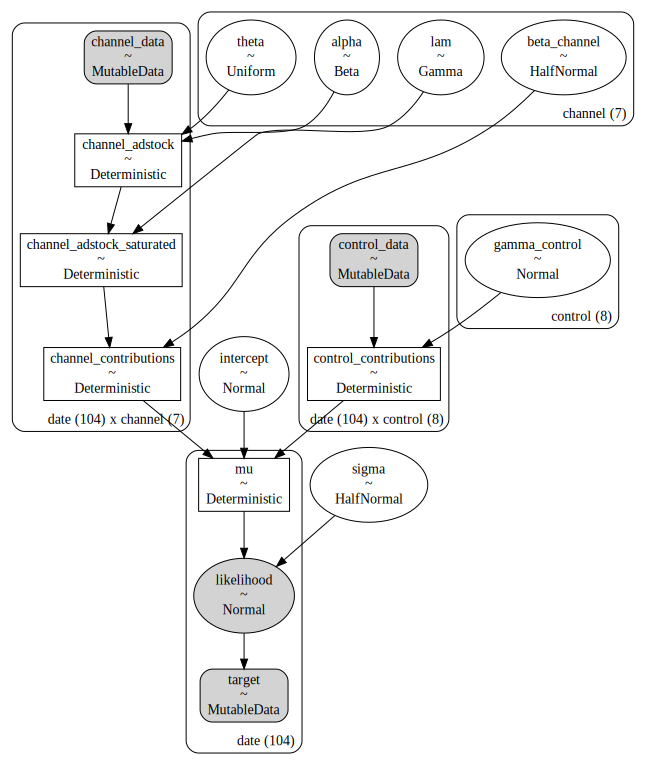

In [13]:
pm.model_to_graphviz(model=mmm.model)

# Model Fitting

We use the fit method provided [here](ttps://github.com/pymc-labs/pymc-marketing/blob/12f40d550c9aef4660f75895723857bcd79e2731/pymc_marketing/mmm/base.py#L111) which itself uses the pymc method: [pymc.sample()](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample.html). We run 4 independent chains which each draw 5000 points. We set our acceptance ratio to be 98%. All these settings were arrived at after several trial-and-error attempts to stabilise the convergence.

In [14]:
# settings for fitting

draws = 5_000 # number of samples to draw; tuned samples discarded by defalt
chains = 4 # number of MCMC chains
target_accept = 0.98

In [15]:
# setting random seed
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# fitting
mmm.fit(target_accept=target_accept, chains=chains, draws=draws, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, theta, lam, sigma, gamma_control]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 417 seconds.


## Model Diagnostics

The [fit_result](https://github.com/pymc-labs/pymc-marketing/blob/12f40d550c9aef4660f75895723857bcd79e2731/pymc_marketing/mmm/base.py#L126) property contains the `pymc` trace object, which we use to run diagnostics on our model.

In [16]:
mmm.fit_result

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

### Summary of our trace

In the following analyses, HDI: Highest Density Interval 

In [17]:
az.summary(
    data=mmm.fit_result,
    var_names=["intercept", "beta_channel", "alpha", "theta", "lam", "gamma_control", "sigma"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.145,0.057,0.035,0.244,0.001,0.000,7945.0,10423.0,1.0
beta_channel[x1],0.207,0.213,0.000,0.566,0.002,0.002,6308.0,6767.0,1.0
beta_channel[x2],0.262,0.200,0.001,0.593,0.002,0.002,6399.0,4949.0,1.0
beta_channel[x3],0.130,0.139,0.000,0.327,0.002,0.001,4755.0,11266.0,1.0
beta_channel[x4],0.187,0.209,0.000,0.537,0.002,0.002,5418.0,8813.0,1.0
beta_channel[x5],0.059,0.098,0.000,0.191,0.001,0.001,10174.0,11603.0,1.0
beta_channel[x6],0.067,0.095,0.000,0.200,0.001,0.001,10538.0,11110.0,1.0
beta_channel[x7],0.374,0.200,0.068,0.730,0.003,0.002,3803.0,2710.0,1.0
alpha[x1],0.296,0.207,0.000,0.665,0.001,0.001,19485.0,10027.0,1.0
alpha[x2],0.288,0.188,0.000,0.617,0.002,0.001,13101.0,9362.0,1.0


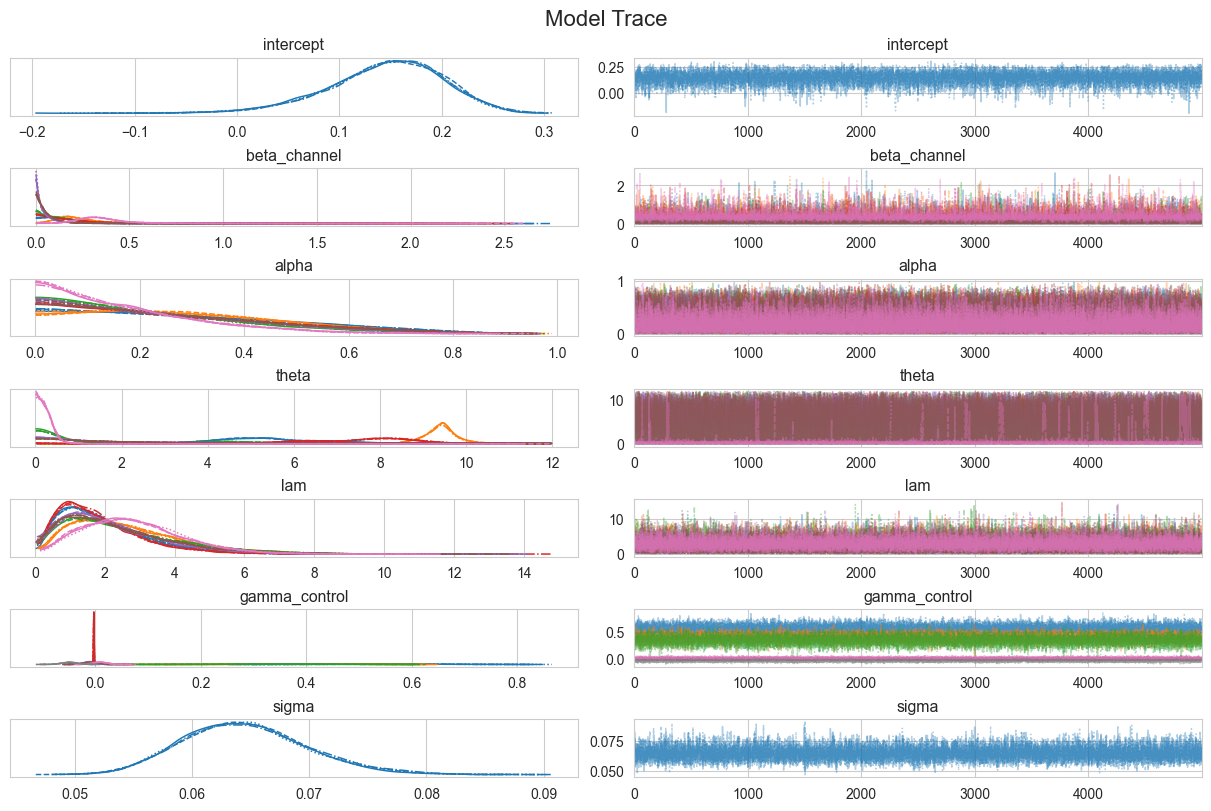

In [18]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=["intercept", "beta_channel", "alpha",  "theta", "lam", "gamma_control", "sigma"],
    compact=True,
    backend_kwargs={"figsize": (12, 8), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

## Model Parameters

### **Media parameters**

We plot the posterior probability distributions of the model parameters using violin plots, that show the actual posterior distribution. Inside each violin plot is a reduced box plot, that marks the 50% quartile (median) and the edges mark the 25% and 75% quartile. This is true for all the parameters below, and is made using the plotting helper function below.

In [19]:
# Credit: https://github.com/pymc-labs/pymc-marketing/blob/846e553e55a4f2a68ce0ad85793a569f81496209/pymc_marketing/mmm/base.py#L340

def plot_channel_parameter(model, param_name: str, **plt_kwargs: Any) -> plt.Figure:
        if param_name not in ["alpha", "lam", "beta_channel", "theta"]:
            raise ValueError(f"Invalid parameter name: {param_name}")

        param_samples_df = pd.DataFrame(
            data=az.extract(data=model.fit_result, var_names=[param_name]).T,
            columns=model.channel_columns,
        )

        fig, ax = plt.subplots(**plt_kwargs)
        sns.violinplot(data=param_samples_df, orient="h", ax=ax)
        ax.set(
            title=f"Posterior Predictive {param_name} Parameter",
            xlabel=param_name,
            ylabel="channel",
        )
        return fig

#### **$\alpha_m$: retention rate**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


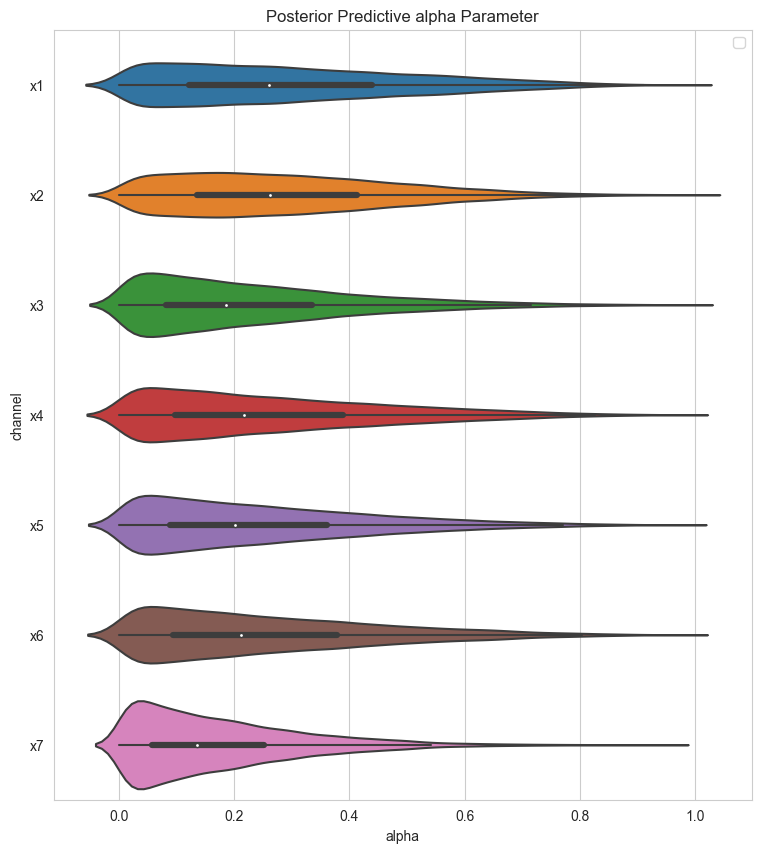

In [20]:
fig = plot_channel_parameter(mmm, param_name="alpha", figsize=(9, 10))
ax = fig.axes[0]
ax.legend(loc="upper right");

#### **$\theta_m$: Delay parameter**

**Inferences:**
* x1, x2, x4 seem to be spend channels where there is a prominent delay in the impact of media spend on the target variable, revenue.
* x3/4 show multi-modality
* x7 seem immediate and could have sufficed with geometric adstock (would have saved us a parameter)
* x6/5 have highly, but not completely uninformed, posterior distributions.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


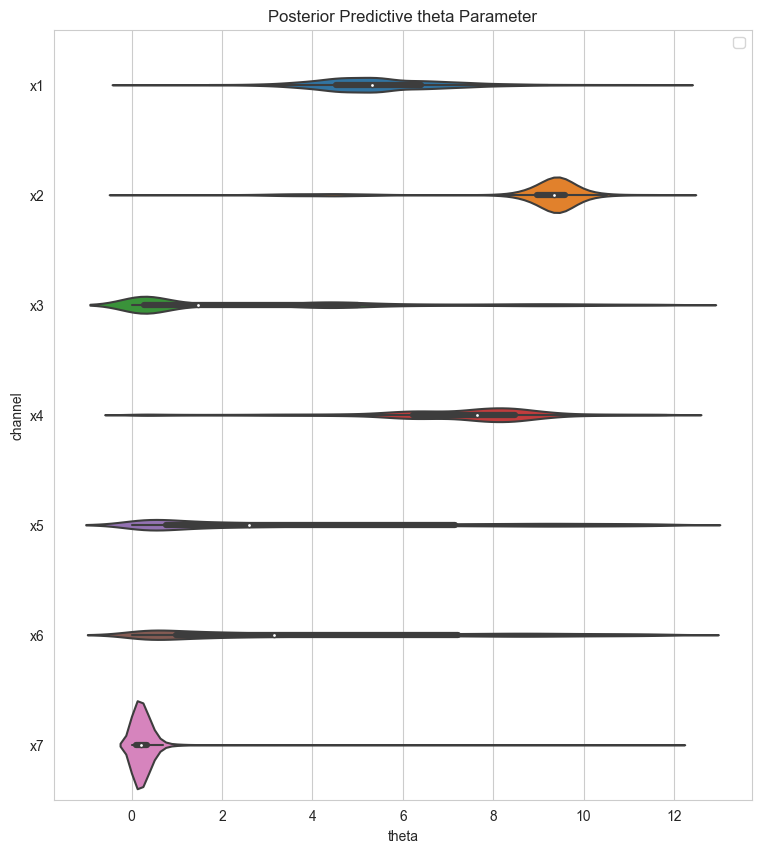

In [21]:
fig = plot_channel_parameter(mmm, param_name="theta", figsize=(9, 10))
ax = fig.axes[0]
ax.legend(loc="upper right");

#### **$\beta_m$: regression coefficient for shape transformation**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


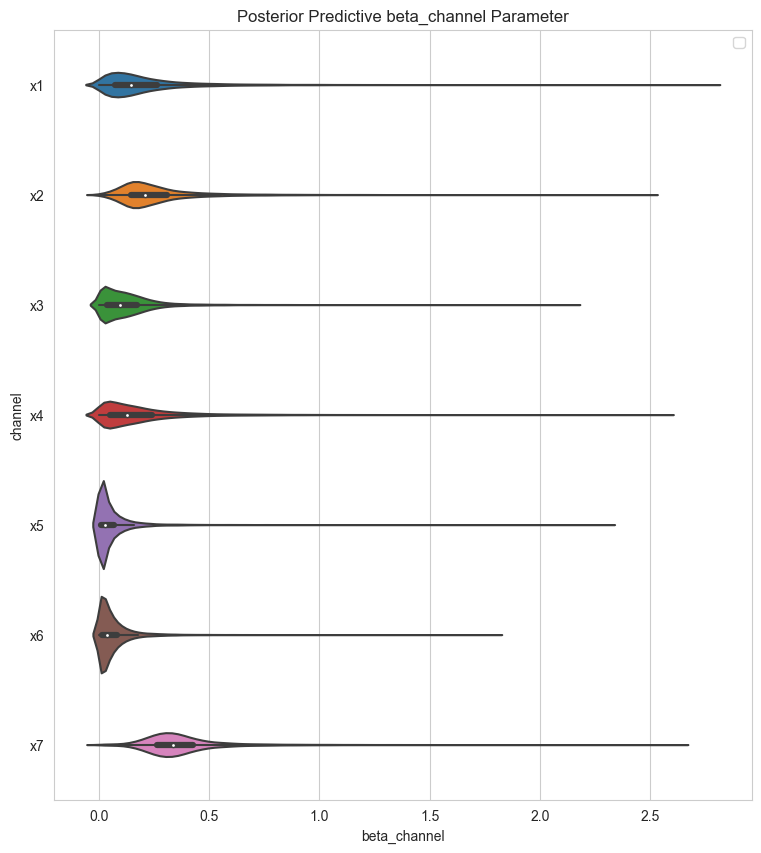

In [22]:
fig = plot_channel_parameter(mmm, param_name="beta_channel", figsize=(9, 10))
ax = fig.axes[0]
ax.legend(loc="upper right");

#### **$\lambda_m$: Saturation coefficient**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


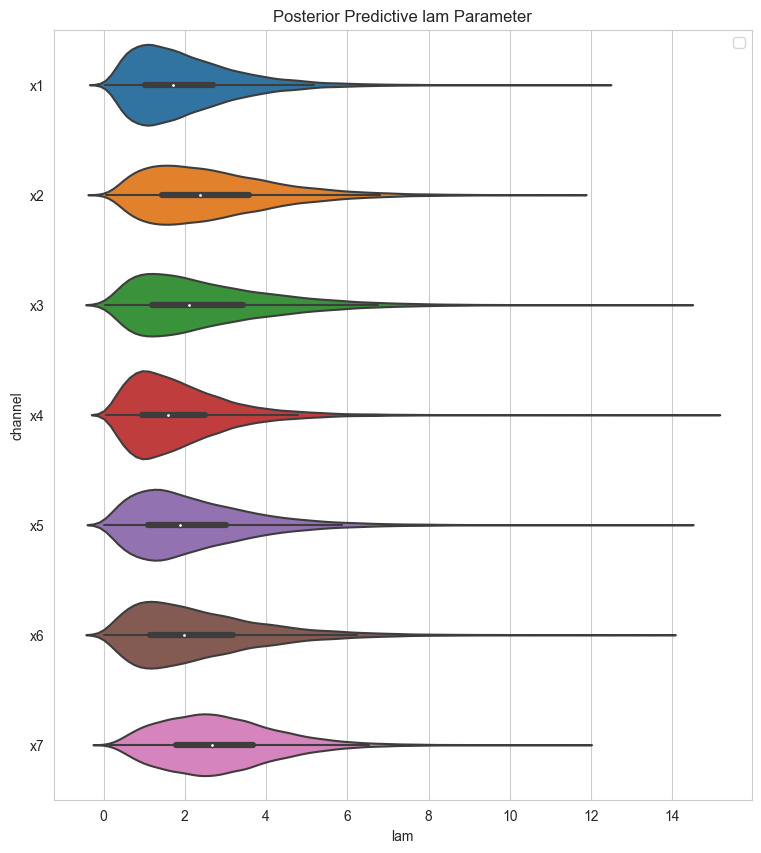

In [23]:
fig = plot_channel_parameter(mmm, param_name="lam", figsize=(9, 10))
ax = fig.axes[0]
ax.legend(loc="upper right");

### **Revenue: Prior vs Posterior**

We plot the prior and posterior distribution of the target variable, revenue $y_t$. Note that these are the rescaled variables. In both cases, the darker/lighter blue bands represent 50/94% credible intervals. The black line shows the true value. 

Sampling: [alpha, beta_channel, gamma_control, intercept, lam, likelihood, sigma, theta]


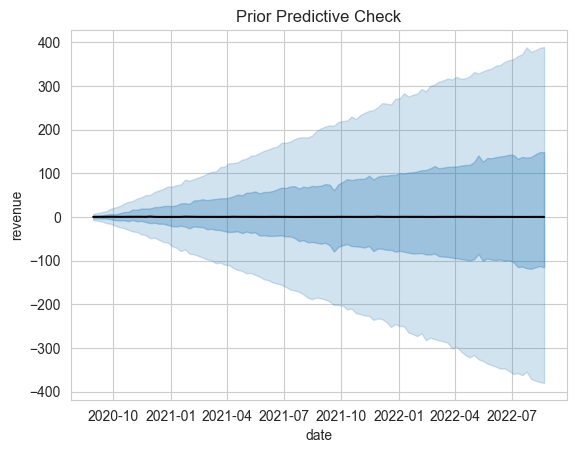

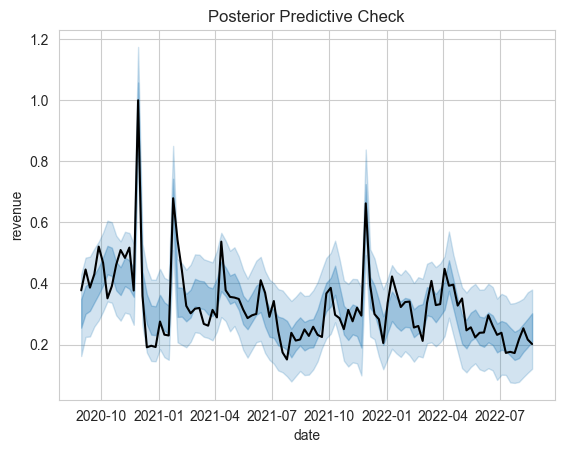

In [24]:
# Credit:
# plot_prior_predictive: https://github.com/pymc-labs/pymc-marketing/blob/12f40d550c9aef4660f75895723857bcd79e2731/pymc_marketing/mmm/base.py#L138
# draws samples from the prior distributions on the individual parameters
# and transforms into a prior on the target variable

# plot_posterior_predictive: https://github.com/pymc-labs/pymc-marketing/blob/12f40d550c9aef4660f75895723857bcd79e2731/pymc_marketing/mmm/base.py#L180
# draws samples from the posterior samples on the rescaled revenue/target variable,
# computes the credible levels and compares against the actuals

mmm.plot_prior_predictive()
mmm.plot_posterior_predictive();

### **Revenue: Breakdown into contributions**

We further decompose the posterior probability distribution into it's different components:

1. intercept which defines the baseline revenue [green curve]
2. contributions from control events: sesasonality, trend and revenue spikes [orange curve]
3. contributions from media channels [blue curve]

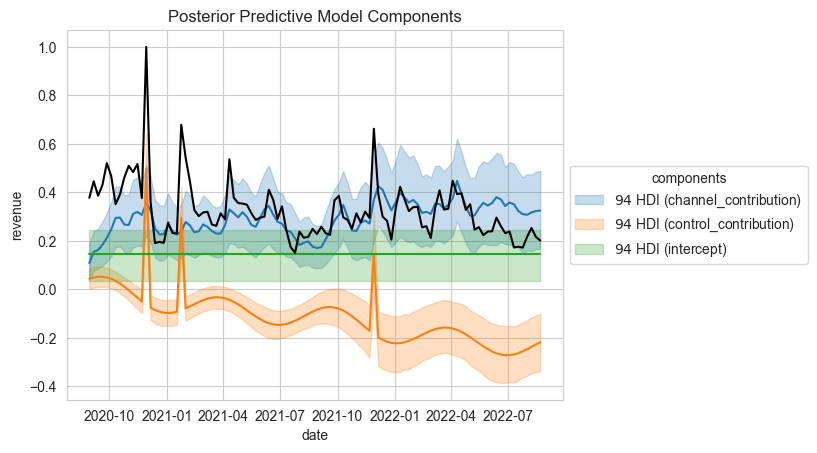

In [25]:
# credit: https://github.com/pymc-labs/pymc-marketing/blob/12f40d550c9aef4660f75895723857bcd79e2731/pymc_marketing/mmm/base.py#L233

mmm.plot_components_contributions();

### **Revenue: Original scale (not MaxAbsScaled)**

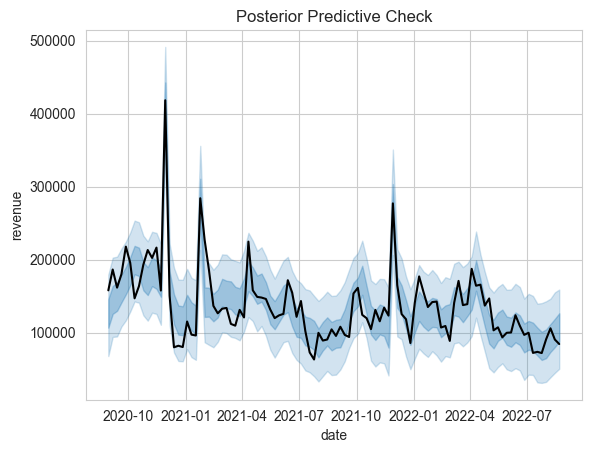

In [26]:
mmm.plot_posterior_predictive(original_scale=True);

# Model Evaluation: BIC

One way to evaluate the performance, and select the most appropriate model, is to calculate the Bayesian Information Criterion (BIC), defined as:

$\text{BIC} = -2 \text{log}\hat{\mathcal{L}} + k \text{log}(n)$

where:

* $\hat{\mathcal{L}}$: maximized value of the likelihood function
* $k$: number of free parameters
* $n$: sample size. log Lˆ is approximated by the average of the log likelihood plugging in the posterior samples of the parameters after the MCMC sampler has burned in

Text(0.5, 0, 'log$\\mathcal{L}$')

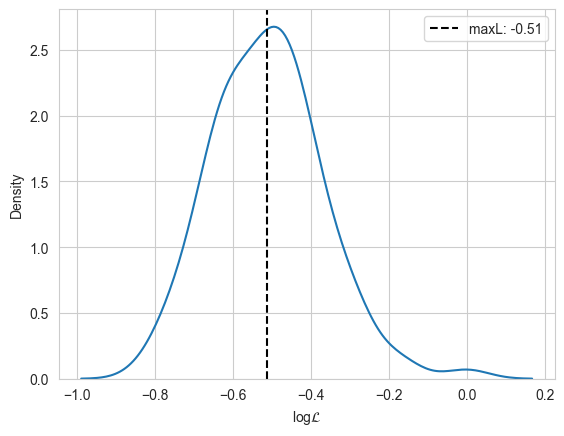

In [61]:
import statistics

## log-likelihood values
loglike_values = np.log10(mmm.fit_result.observed_data.likelihood.values)

# maximum likelihood point
maxL = statistics.median(loglike_values)

fig, ax = plt.subplots()
sns.kdeplot(loglike_values, ax=ax)
ax.axvline(x=maxL, color='k', ls='dashed', label=f'maxL: {maxL:.2}')
ax.legend()
ax.set_xlabel('log$\mathcal{L}$')

In [67]:
k = 7 # no. of free parameters
n = 104 # sample size
bic = -2*maxL + k*np.log10(n)
print("BIC for this model:", bic)


BIC for this model: 15.142351672542187


## Media Channels Contribution Share: 
### What are the relative contribution of each channel to the target variable?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


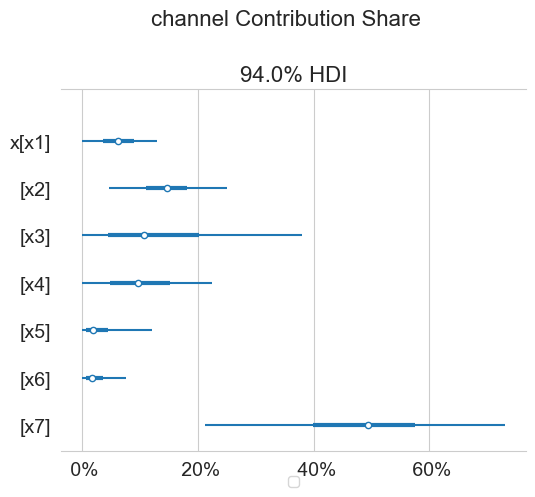

In [68]:
# Credit: https://github.com/pymc-labs/pymc-marketing/blob/93e34bda1c2d264be6b84bf2f113785b9d818ed0/pymc_marketing/mmm/base.py#L421

fig = mmm.plot_channel_contribution_share_hdi()
ax = fig.axes[0]
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=1);

### What are the relative contribution of each channel to the target variable over time?

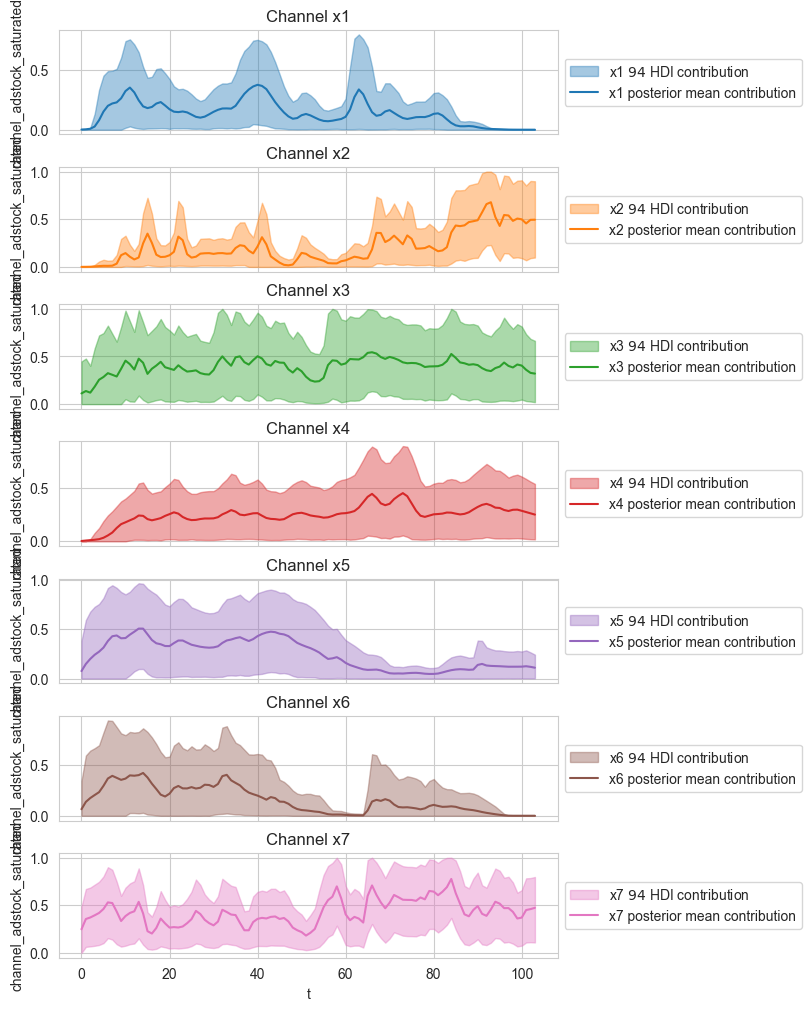

In [30]:
mean_estimated_channels_contribution = az.extract(
    data=mmm.fit_result,
    group="posterior",
    var_names=["channel_adstock_saturated"]
).mean("sample")

estimated_channels_contribution_hdi = az.hdi(ary=mmm.fit_result)["channel_adstock_saturated"]

fig, ax = plt.subplots(
    nrows=7, figsize=(8, 10), ncols=1, sharex=True, sharey=False, layout="constrained"
)

for i, x, in enumerate([f"x{i}" for i in range(1,8)]):
    ax[i].fill_between(
        x=df["t"],
        y1=estimated_channels_contribution_hdi.sel(channel=x)[:, 0],
        y2=estimated_channels_contribution_hdi.sel(channel=x)[:, 1],
        color=f"C{i}",
        label=f"{x} $94%$ HDI contribution",
        alpha=0.4,
    )
    sns.lineplot(
        x=df["t"],
        y=mean_estimated_channels_contribution.sel(channel=x),
        color=f"C{i}",
        label=f"{x} posterior mean contribution",
        ax=ax[i]
    )
    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {x}")

Text(0.5, 0.98, 'Contribution Plots')

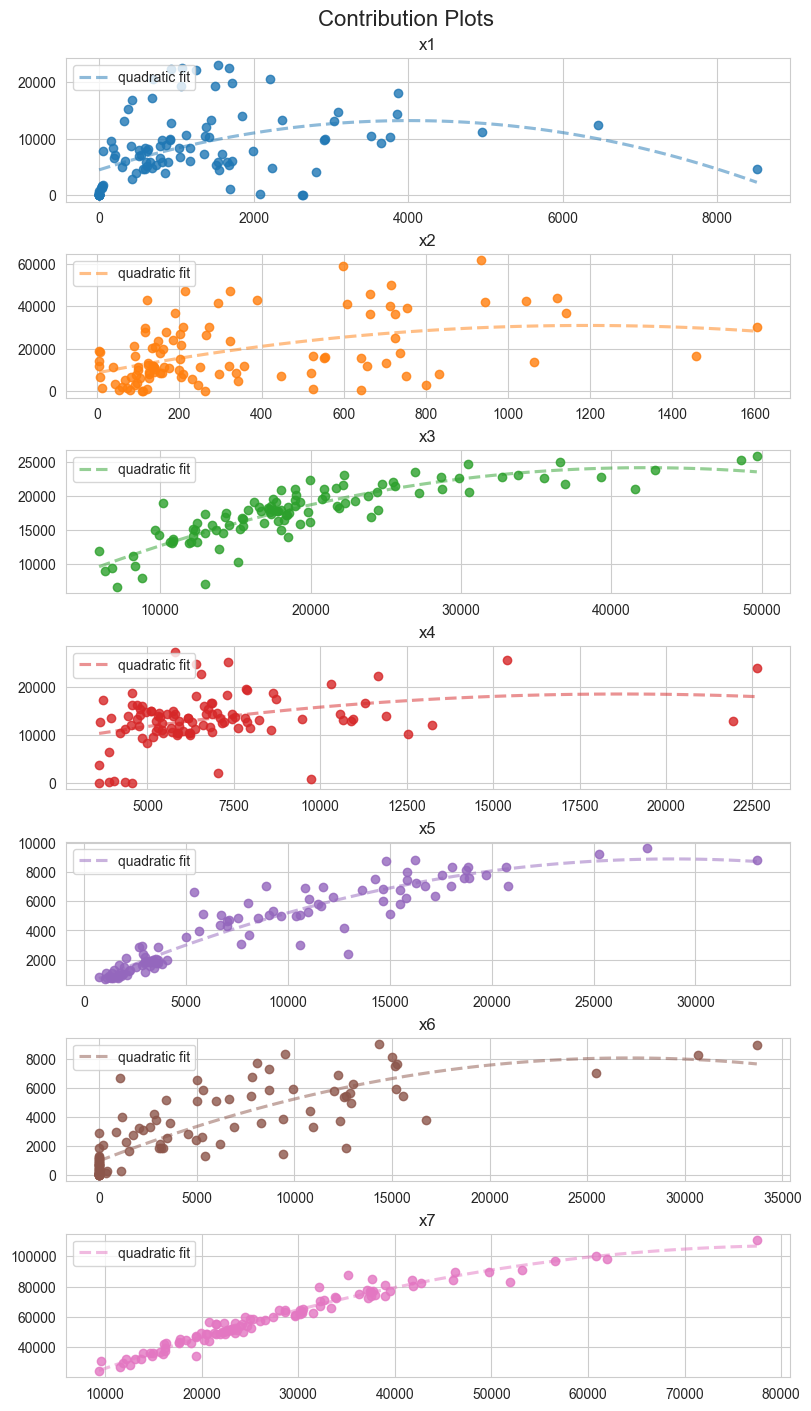

In [79]:
fig, axes = plt.subplots(
            nrows=mmm.n_channel,
            ncols=1,
            sharex=False,
            sharey=False,
            figsize=(8, 2 * mmm.n_channel),
            layout="constrained",
        )

# Credit: https://github.com/pymc-labs/pymc-marketing/blob/93e34bda1c2d264be6b84bf2f113785b9d818ed0/pymc_marketing/mmm/base.py#L358

channel_contributions = mmm.compute_channel_contribution_original_scale().mean(["chain", "draw"])
for i, channel in enumerate(mmm.channel_columns):
    ax = axes[i]
    sns.regplot(
        x=mmm.data[mmm.channel_columns].to_numpy()[:, i],
        y=channel_contributions.sel(channel=channel),
        color=f"C{i}",
        order=2,
        ci=None,
        line_kws={
            "linestyle": "--",
            "alpha": 0.5,
            "label": "quadratic fit",
        },
        ax=ax,
    )
    ax.legend(loc="upper left")
    ax.set(title=f"{channel}")

fig.suptitle("Contribution Plots", fontsize=16)



# ROI: ROAS/mROAS

The last question in the challenge asks:
> * Can you derive ROI (return on investment) estimates per channel? What is the best channel in terms of ROI?

We choose, as our ROI metric, **Return on Ad Spend (ROAS)** per media channel. ROAS is the change in revenue per euro spent on the medium. For this calculation, we assume the spends in the different channels to be independent of each other, i.e., change in spend in one channel does not affect others.

As a simple approximation, we consider: **ROAS of a particular media channel is the contribution of that media channel divided by it's cost.**

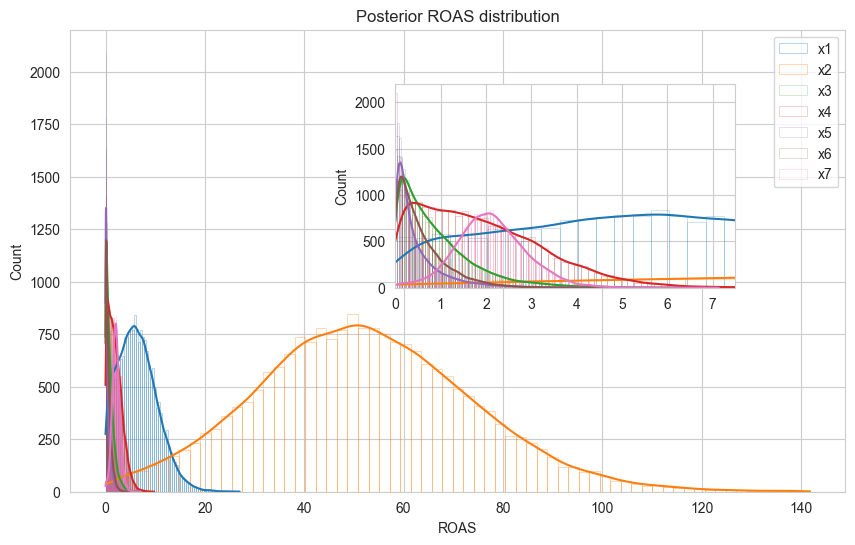

In [98]:
# contributions of media variables
channel_contributions = mmm.compute_channel_contribution_original_scale().stack(sample=("chain", "draw")).sum("date") 

# costs of media variables
channel_costs = df[[f"x{i}" for i in range(1,8)]].sum().to_numpy()[..., None]

roas_samples = (
    channel_contributions
    / channel_costs 
)

fig, ax = plt.subplots(figsize=(10, 6))
for x in [f"x{i}" for i in range(1,8)]:
    sns.histplot(roas_samples.sel(channel=x).to_numpy(), alpha=0.3, kde=True, ax=ax, fill=False, label=x)

left, bottom, width, height = [0.45, 0.45, 0.34, 0.34]
ax2 = fig.add_axes([left, bottom, width, height]) 
for x in [f"x{i}" for i in range(1,8)]:
    sns.histplot(roas_samples.sel(channel=x).to_numpy(), alpha=0.3, kde=True, ax=ax2, label=x, fill=False)
ax2.set_xlim([0,7.5])

ax.legend(loc="upper right")
ax.set(title="Posterior ROAS distribution", xlabel="ROAS");

# Followups

* Modelling
  * Try our other scaling methods, like MinMaxScaling
  * Id better ways to distinguish geometric and delayed adstock variables and apply the transformations separately
  * Differentiate shape effects based on which channels they correspond to
  * Define variable-specific ordering depending on behaviour of spends
  * Different priors
  * Different likelihoods

# Challenges with Bayesian MMM’s
In one way, MMMs are conceptually simple. So how hard can it be to implement these kinds of models in a Bayesian framework? Well, not so fast! Things can get tricky when moving from concepts to implementation. Here is a list of possible stumbling points—which are precisely the kind of modeling decisions that our team at PyMC Labs can help with:

* Which likelihood function to choose? There are several feasible options here. Suppose we are modeling customer counts. We could consider discrete distributions like the Poisson distribution but also the Negative binomial distribution would be a potential option. Alternatively, if the number of customers is very large, we may also choose a Normal distribution; or perhaps a distribution with longer tails, such as the Cauchy or Student’s T distribution.

* What priors to use? Bayesian MMM’s will require priors over numerous parameters, such as regression coefficients on the control measures and the parameters in the reach and adstock functions. It is easy to end up with hundreds of parameters for state-of-the-art models. Some choices of priors may be less appropriate than others and lead to bad convergence problems. And how, exactly, should we use the data from lift tests to improve these priors?

* How should the reach and adstock functions be parameterized? The parametric forms of reach and adstock functions also have many options. Some ways of parameterizing these functions will be more interpretable than others and more readily provide insights to drive decision-making.

* How to select the correct model? In all likelihood, at least during development, dozens of different MMM variations may be considered. How can we rapidly assess which ones are most promising? It may be useful to have a system in place that allows rapid experimentation, allowing different background variables to be brought in and out of the MMM. Having a coherent and easy-to-change setup is very useful in supporting experimentation and evaluation of ‘what if’ questions.

* How can we ensure rigorous, correct, and fast inference? While Bayesian modeling is very powerful when working with real-world models for decision making it is crucial to ensure the inference is correct. There can be a number of problems that may trap a novice here, such as the correlation between MCMC chains, divergences in sampling, over-specified models… and even subtle aspects about interpreting the interplay between the model, the priors, and the data.